In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab
import torch
import sys
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM import TMCRBM
import functions

from scipy.integrate import simps
from scipy import stats
import h5py

device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

# RBM Tethered Monte-Carlo Sampling 1D
### Data : 
 - $N_v = 1000$
 - $N_s = 2000$
 - 5 clusters along 1 dimension : axe $= (1,1,1,1,1,\cdots,1)$

In [2]:
data = torch.load("../dataset/data_5c_01.pt")

## Machine déjà entrainée

In [3]:
W = torch.tensor(np.genfromtxt('../dataset/C1d5c/rbm_W.dat').T, device=device, dtype=dtype)
vbias = torch.tensor(np.genfromtxt('../dataset/C1d5c/rbm_vis.dat'), device=device, dtype=dtype)
hbias = -torch.tensor(np.genfromtxt('../dataset/C1d5c/rbm_hid.dat'), device=device, dtype=dtype)
lr = 0.01
l2 = 0
NGibbs = 10
annSteps = 0
mb_s = 500
num_pcd = 500
Nh = W.shape[0]
Nv = W.shape[1]
print(Nh)
ep_max = 100

myRBM = TMCRBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)

myRBM.W = 4*W
myRBM.vbias = 2*vbias - 2*W.sum(0)
myRBM.hbias = 2*hbias - 2*W.sum(1)
_, _, V = torch.svd(myRBM.W)


20


In [4]:
nb_chain = 10 # Nb de chaines pour chaque w_hat
it_mcmc = 150 # Nb it_mcmc pour chaque chaine
it_mean = 100 # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 20000 # Contrainte
nb_point = 15000 # Nb de points de discrétisation pour w_hat
xmin = -0.0 
xmax = 1.0
border_length=0.1
p_m, grad_pot, potential, w_hat_b = functions.ComputeProbabilityTMC1D(myRBM, data, nb_chain, it_mcmc, it_mean, N, nb_point, border_length, V, device)
w_hat_b = w_hat_b.cpu()
p_m = p_m.cpu()

In [5]:
gen_data = functions.SampleTMC1D(p_m, w_hat_b, 1000)
gen_data = gen_data.cpu().numpy()

In [6]:
vinit = torch.bernoulli(torch.rand(
        (myRBM.Nv, 10000), device=myRBM.device, dtype=myRBM.dtype))

si, mi, _, _ = myRBM.Sampling(vinit, it_mcmc=10000)
proj_gen = torch.mm(si.T, V).cpu().numpy()/myRBM.Nv**.5

<ipython-input-7-26fe9559f39b>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_data =torch.mm(torch.tensor(data, device = device, dtype = dtype), V).cpu()/myRBM.Nv**0.5


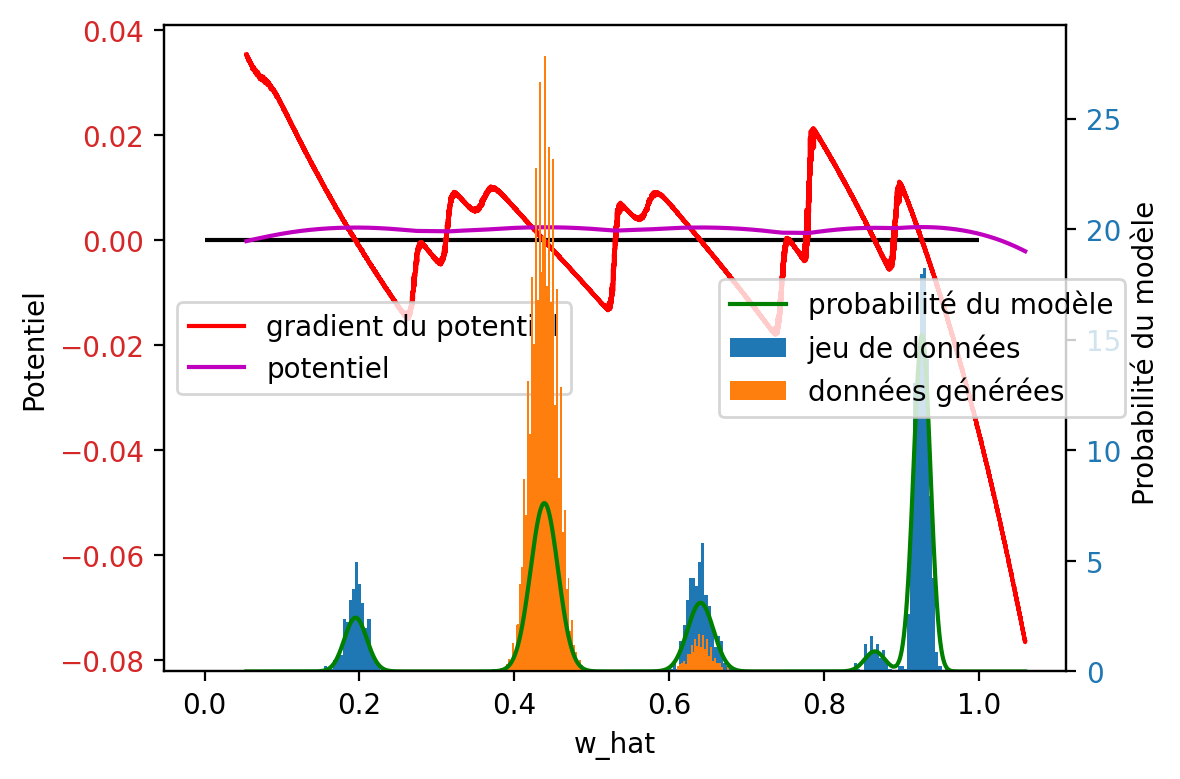

In [7]:
proj_data =torch.mm(torch.tensor(data, device = device, dtype = dtype), V).cpu()/myRBM.Nv**0.5
fig, ax1 = plt.subplots(dpi = 200)

color = 'tab:red'
ax1.set_xlabel("w_hat")
ax1.plot(w_hat_b,grad_pot,color='red', label = "gradient du potentiel")
ax1.hlines(0,0,1, color = 'black')
#ax1.scatter(proj_gen[:,0], proj_gen[:,1],alpha=0.2, label = 'data_gen')
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(w_hat_b[1:], potential, label = "potentiel", color = "m")
ax1.set_ylabel("Potentiel")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
rdm_y = torch.randn(proj_data[:,0].shape)/20
ax2.hist(proj_data[:,0].numpy(), label = 'jeu de données', density=True, bins=200)
#ax2.hist(gen_data, label='generated data', density=True, bins = 200)
ax2.hist(proj_gen[:,0], label='données générées', density=True, bins = 200)

ax2.plot(w_hat_b[1:], p_m, color = "green", label = "probabilité du modèle")
ax2.set_ylabel("Probabilité du modèle ")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc=6)
ax2.legend(loc=6,bbox_to_anchor=(0.6,0.5))
plt.savefig("../../Stage/rapport/fig/TMC1D_Example.png")
plt.show()

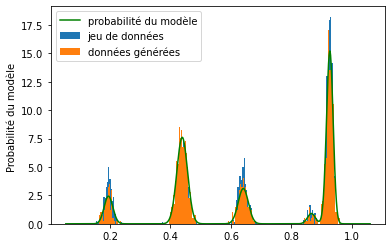

In [8]:
plt.hist(proj_data[:,0].numpy(), label = 'jeu de données', density=True, bins=200)

plt.hist(gen_data, label='données générées', density=True, bins = 200)

plt.plot(w_hat_b[1:], p_m, color = "green", label = "probabilité du modèle")
plt.ylabel("Probabilité du modèle ")
plt.legend()
plt.savefig("../../Stage/rapport/fig/goodsamplingcdf")

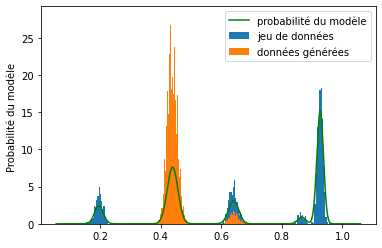

In [9]:
plt.hist(proj_data[:,0].numpy(), label = 'jeu de données', density=True, bins=200)

plt.hist(proj_gen[:,0], label='données générées', density=True, bins = 200)

plt.plot(w_hat_b[1:], p_m, color = "green", label = "probabilité du modèle")
plt.ylabel("Probabilité du modèle ")
plt.legend()
plt.savefig("../../Stage/rapport/fig/badsamplingMCMC.png")

## Entrainement de machine

In [10]:
fname = "../model/TMC1D/AllParametersTMCRBM_NGibbs_50_Nh100_Nv1000_Nmb200_Nepoch50_lr_0.01_N20000_Npoint1000_Nchain15_phase2.h5"
f = h5py.File(fname, "r")
alltimes = []
for t in f['alltime'][:]:
    if 'W'+str(t) in f:
        alltimes.append(t)
alltimes = np.array(alltimes)

In [11]:
singVal = functions.singValTrain_2(fname, alltimes, device = device)

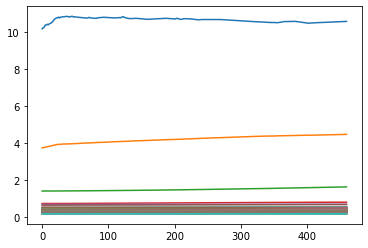

In [12]:
plt.plot(alltimes,singVal);

In [13]:
t = alltimes[-1]
lr = 0.01
NGibbs = 100
annSteps = 0
mb_s = 600
num_pcd = 100
Nh = torch.tensor(f['W0']).shape[0]
Nv = data.shape[1]
ep_max = 10
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V0 = V[:,0]
N = 20000
nb_chain = 15  # Nb de chaines pour chaque w_hat
it_mcmc = 70  # Nb it_mcmc pour chaque chaine
it_mean = 40 # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 20000  # Contrainte
nb_point = 700  # Nb de points de discrétisation pour w_hat
border_length = 0

In [17]:
myRBM = TMCRBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)

myRBM.W = torch.tensor(f['W'+str(t)], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias'+str(t)], device = myRBM.device)
myRBM.vbias = torch.tensor(f['vbias'+str(t)], device = myRBM.device)
_, _, V = torch.svd(myRBM.W)

In [19]:
p_m, grad_pot, potential, w_hat_b = functions.ComputeProbabilityTMC1D(myRBM, data, nb_chain, it_mcmc, it_mean, N, nb_point, border_length, V, device)


In [20]:
w_hat_b = np.array(w_hat_b.cpu())

<ipython-input-21-df8ea091e300>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_data =torch.mm(torch.tensor(data, device = device, dtype = dtype), V).cpu()/myRBM.Nv**0.5


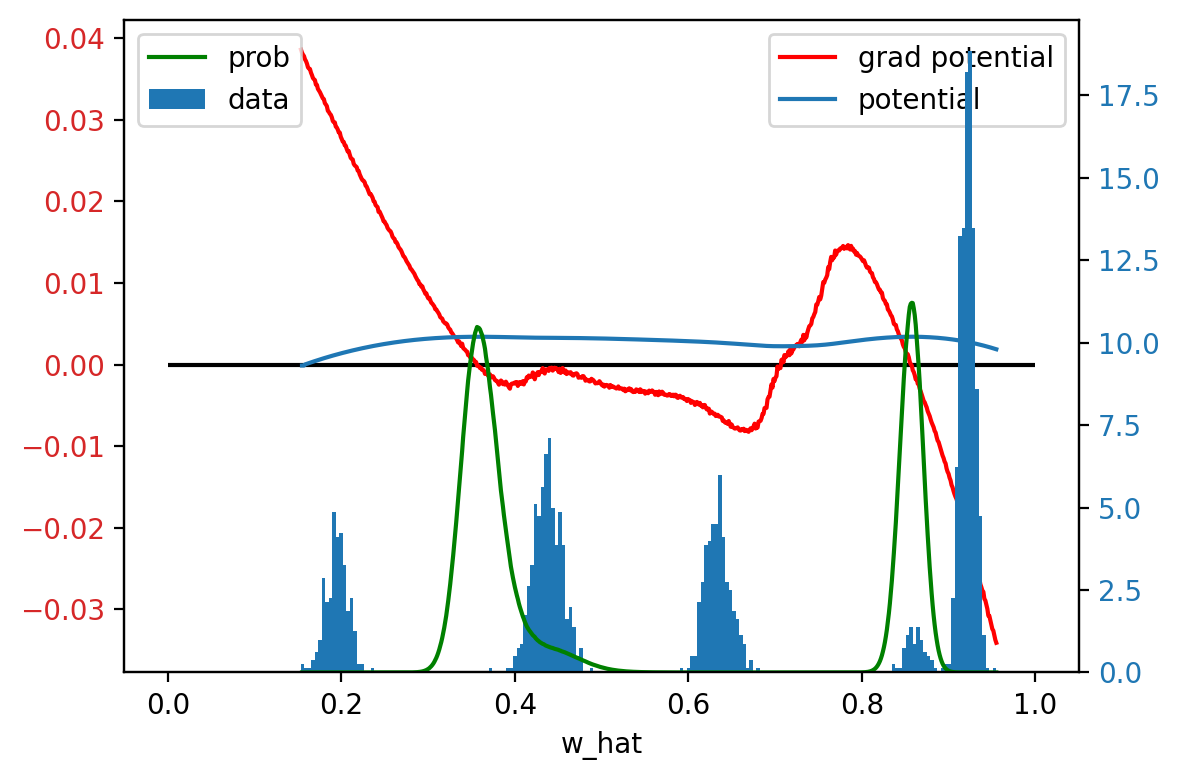

In [21]:
proj_data =torch.mm(torch.tensor(data, device = device, dtype = dtype), V).cpu()/myRBM.Nv**0.5
fig, ax1 = plt.subplots(dpi = 200)

color = 'tab:red'
ax1.set_xlabel("w_hat")
ax1.plot(w_hat_b,grad_pot,color='red', label = "grad potential")
ax1.hlines(0,0,1, color = 'black')
#ax1.scatter(proj_gen[:,0], proj_gen[:,1],alpha=0.2, label = 'data_gen')
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(w_hat_b[1:], potential, label = "potential")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
rdm_y = torch.randn(proj_data[:,0].shape)/20
ax2.hist(proj_data[:,0].numpy(), label = 'data', density=True, bins=200)
ax2.plot(w_hat_b[1:], p_m.cpu(), color = "green", label = "prob")

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend()
ax2.legend()
plt.savefig("../../Stage/rapport/fig/TMC_Example.png")
plt.show()

In [ ]:
gen_data